In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from tools.rsa import compute_similarity
from models.admm import ADMM
from utils.helpers import median_matrix_split, best_pairwise_match, zero_matrix_split
from utils.plotting import plot_images_from_embedding
import seaborn as sns
import pandas as pd

def plot_rank_selection(df_full, df_pos, df_neg):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    # Plot full dataframes with variance across repeats
    sns.lineplot(data=df_full, x="rank", y="rmse", ax=ax1, errorbar="sd")
    ax1.set_title("Full RSM")
    ax1.axvline(
        x=df_full.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )

    sns.lineplot(data=df_pos, x="rank", y="rmse", ax=ax2, errorbar="sd")
    ax2.set_title("Positive")
    ax2.axvline(
        x=df_pos.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )

    sns.lineplot(data=df_neg, x="rank", y="rmse", ax=ax3, errorbar="sd")
    ax3.set_title("Negative")
    ax3.axvline(
        x=df_neg.groupby("rank")["rmse"].mean().idxmin(),
        color="r",
        linestyle="--",
        alpha=0.5,
    )


    plt.tight_layout()
    plt.show()

    # Calculate best ranks using mean RMSE
    rank_pos = df_pos.groupby("rank")["rmse"].mean().idxmin()
    rank_neg = df_neg.groupby("rank")["rmse"].mean().idxmin()
    rank_all = df_full.groupby("rank")["rmse"].mean().idxmin()

    print(f"best rank for positive matrix: {rank_pos}")
    print(f"best rank for negative matrix: {rank_neg}")
    print(f"best rank for all matrix: {rank_all}")

/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


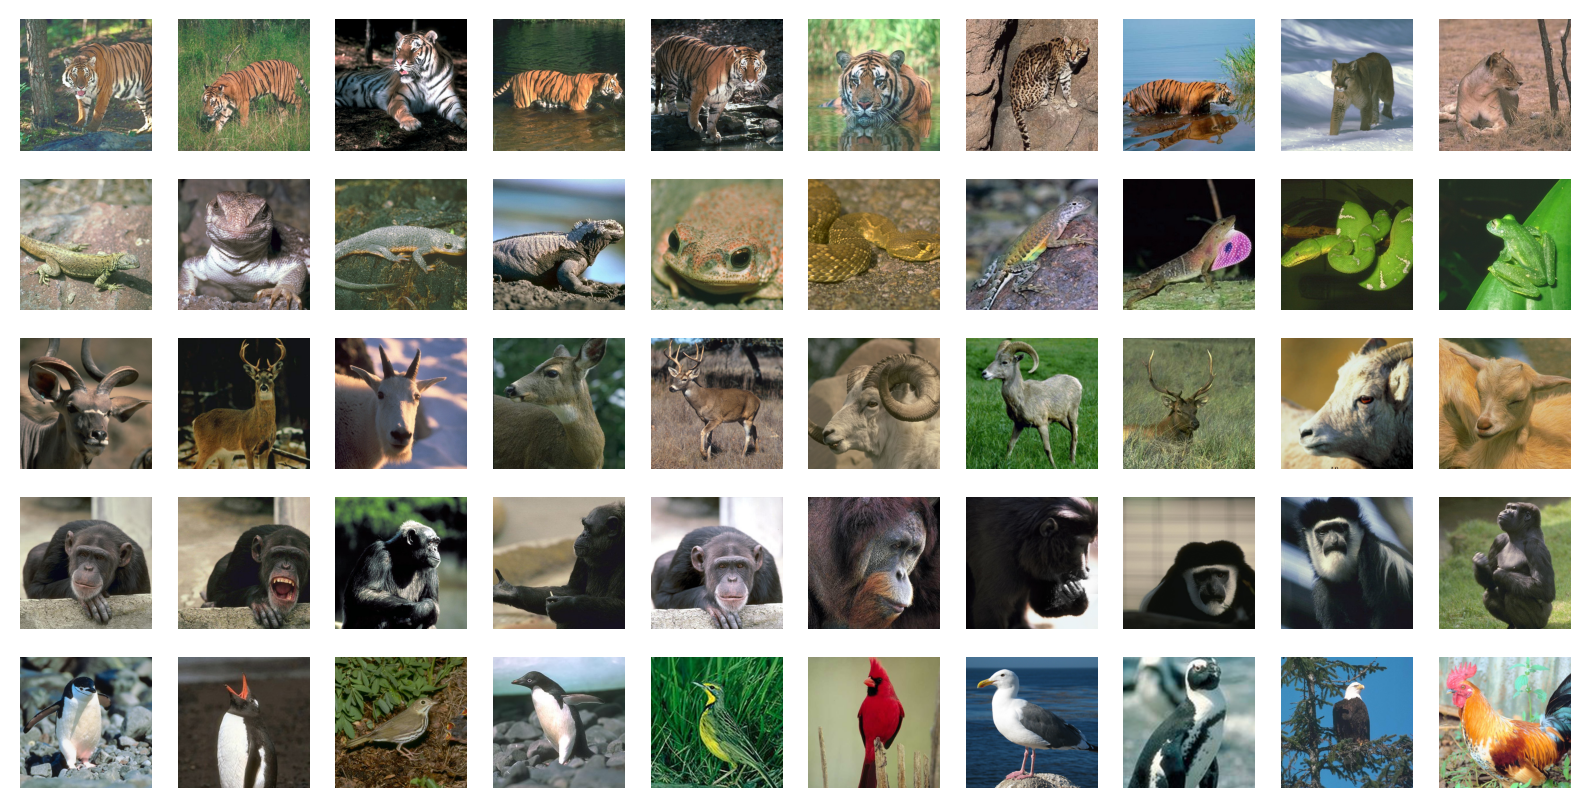

In [3]:
dataset = load_dataset("peterson-animals")
rsm = dataset.rsm

images = dataset.images

rank = 5
model = ADMM(rank=rank, max_outer=50, max_inner=100, tol=0.0, verbose=True, rho=1.0)

w = model.fit_transform(rsm)

fig = plot_images_from_embedding(w, images, top_k=10, dpi=200)

# w_plus = model.fit_transform(s_plus)
# w_minus = model.fit_transform(s_minus)

# fig = plot_images_from_embedding(w_plus, images, top_k=10, dpi=100)
# fig = plot_images_from_embedding(w_minus, images, top_k=10, dpi=100)

### Below we check if there is a power law or somethig similar between the nuber of objects and the optimal training ratio

In [3]:
df = pd.read_csv("../results/rank_detection_full_results.csv")
df

n_objects  train_ratio  trial_id  rank  true_rank       mse  seed
0            100          0.2         0     3          5  0.151947     0
1            100          0.2         0     4          5  0.183004     0
2            100          0.2         0     5          5  0.250534     0
3            100          0.2         0     6          5  0.262501     0
4            100          0.2         0     7          5  0.302082     0
...          ...          ...       ...   ...        ...       ...   ...
20995       1000          0.8        19    18         20  0.011196  4199
20996       1000          0.8        19    19         20  0.006564  4199
20997       1000          0.8        19    20         20  0.001597  4199
20998       1000          0.8        19    21         20  0.001306  4199
20999       1000          0.8        19    22         20  0.000994  4199

[21000 rows x 7 columns]

<Figure size 1920x1440 with 0 Axes>

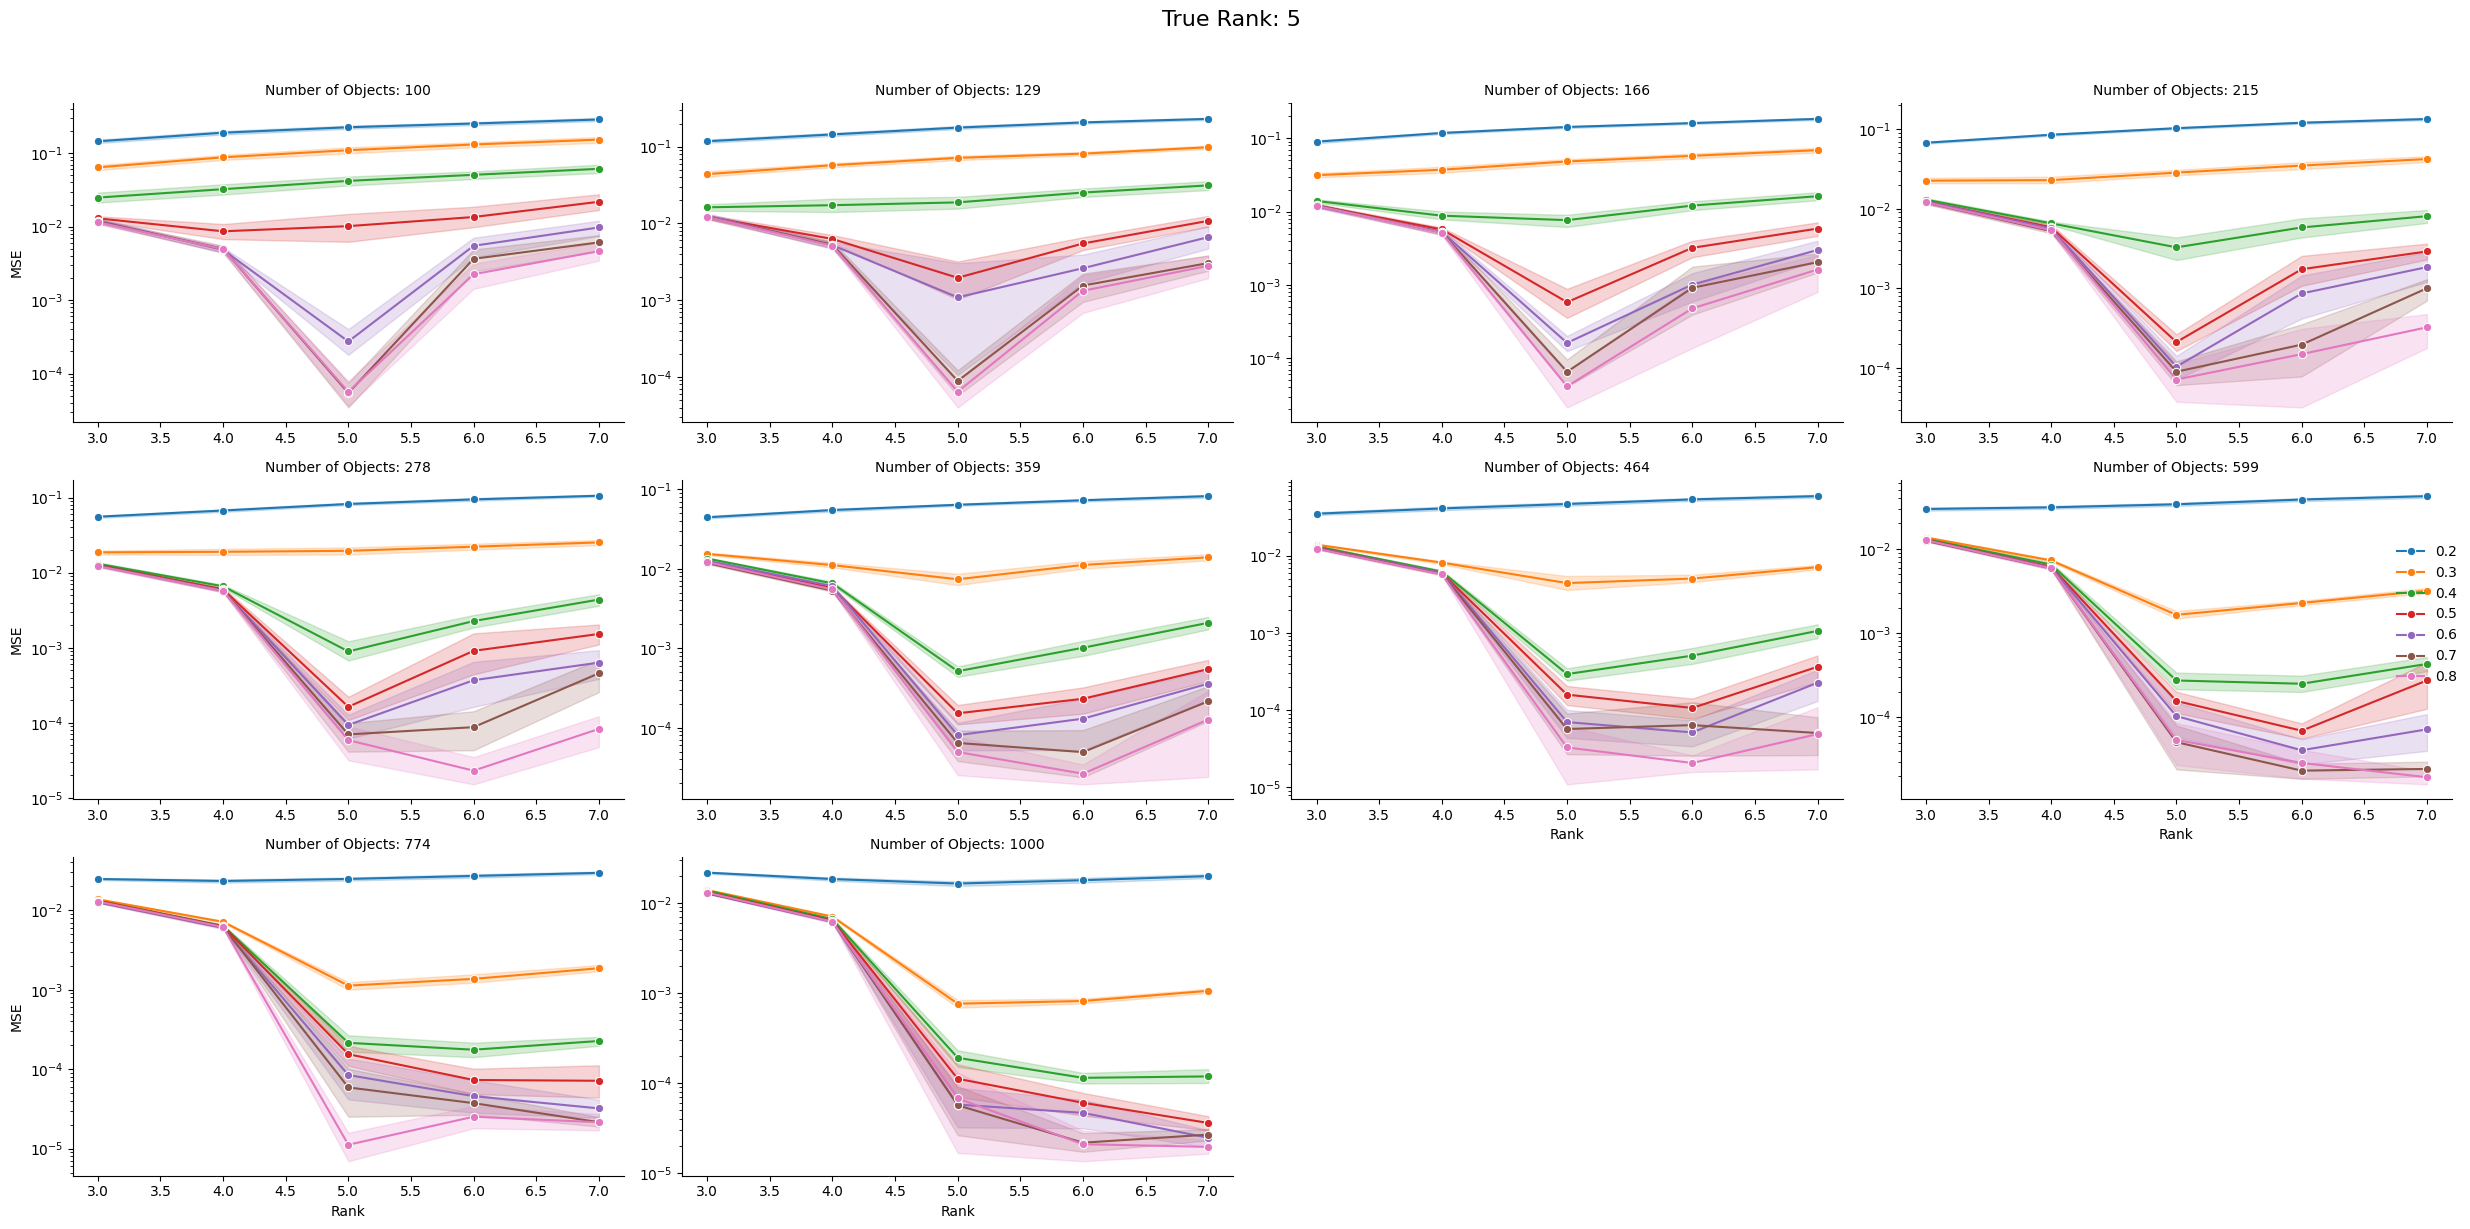

<Figure size 1920x1440 with 0 Axes>

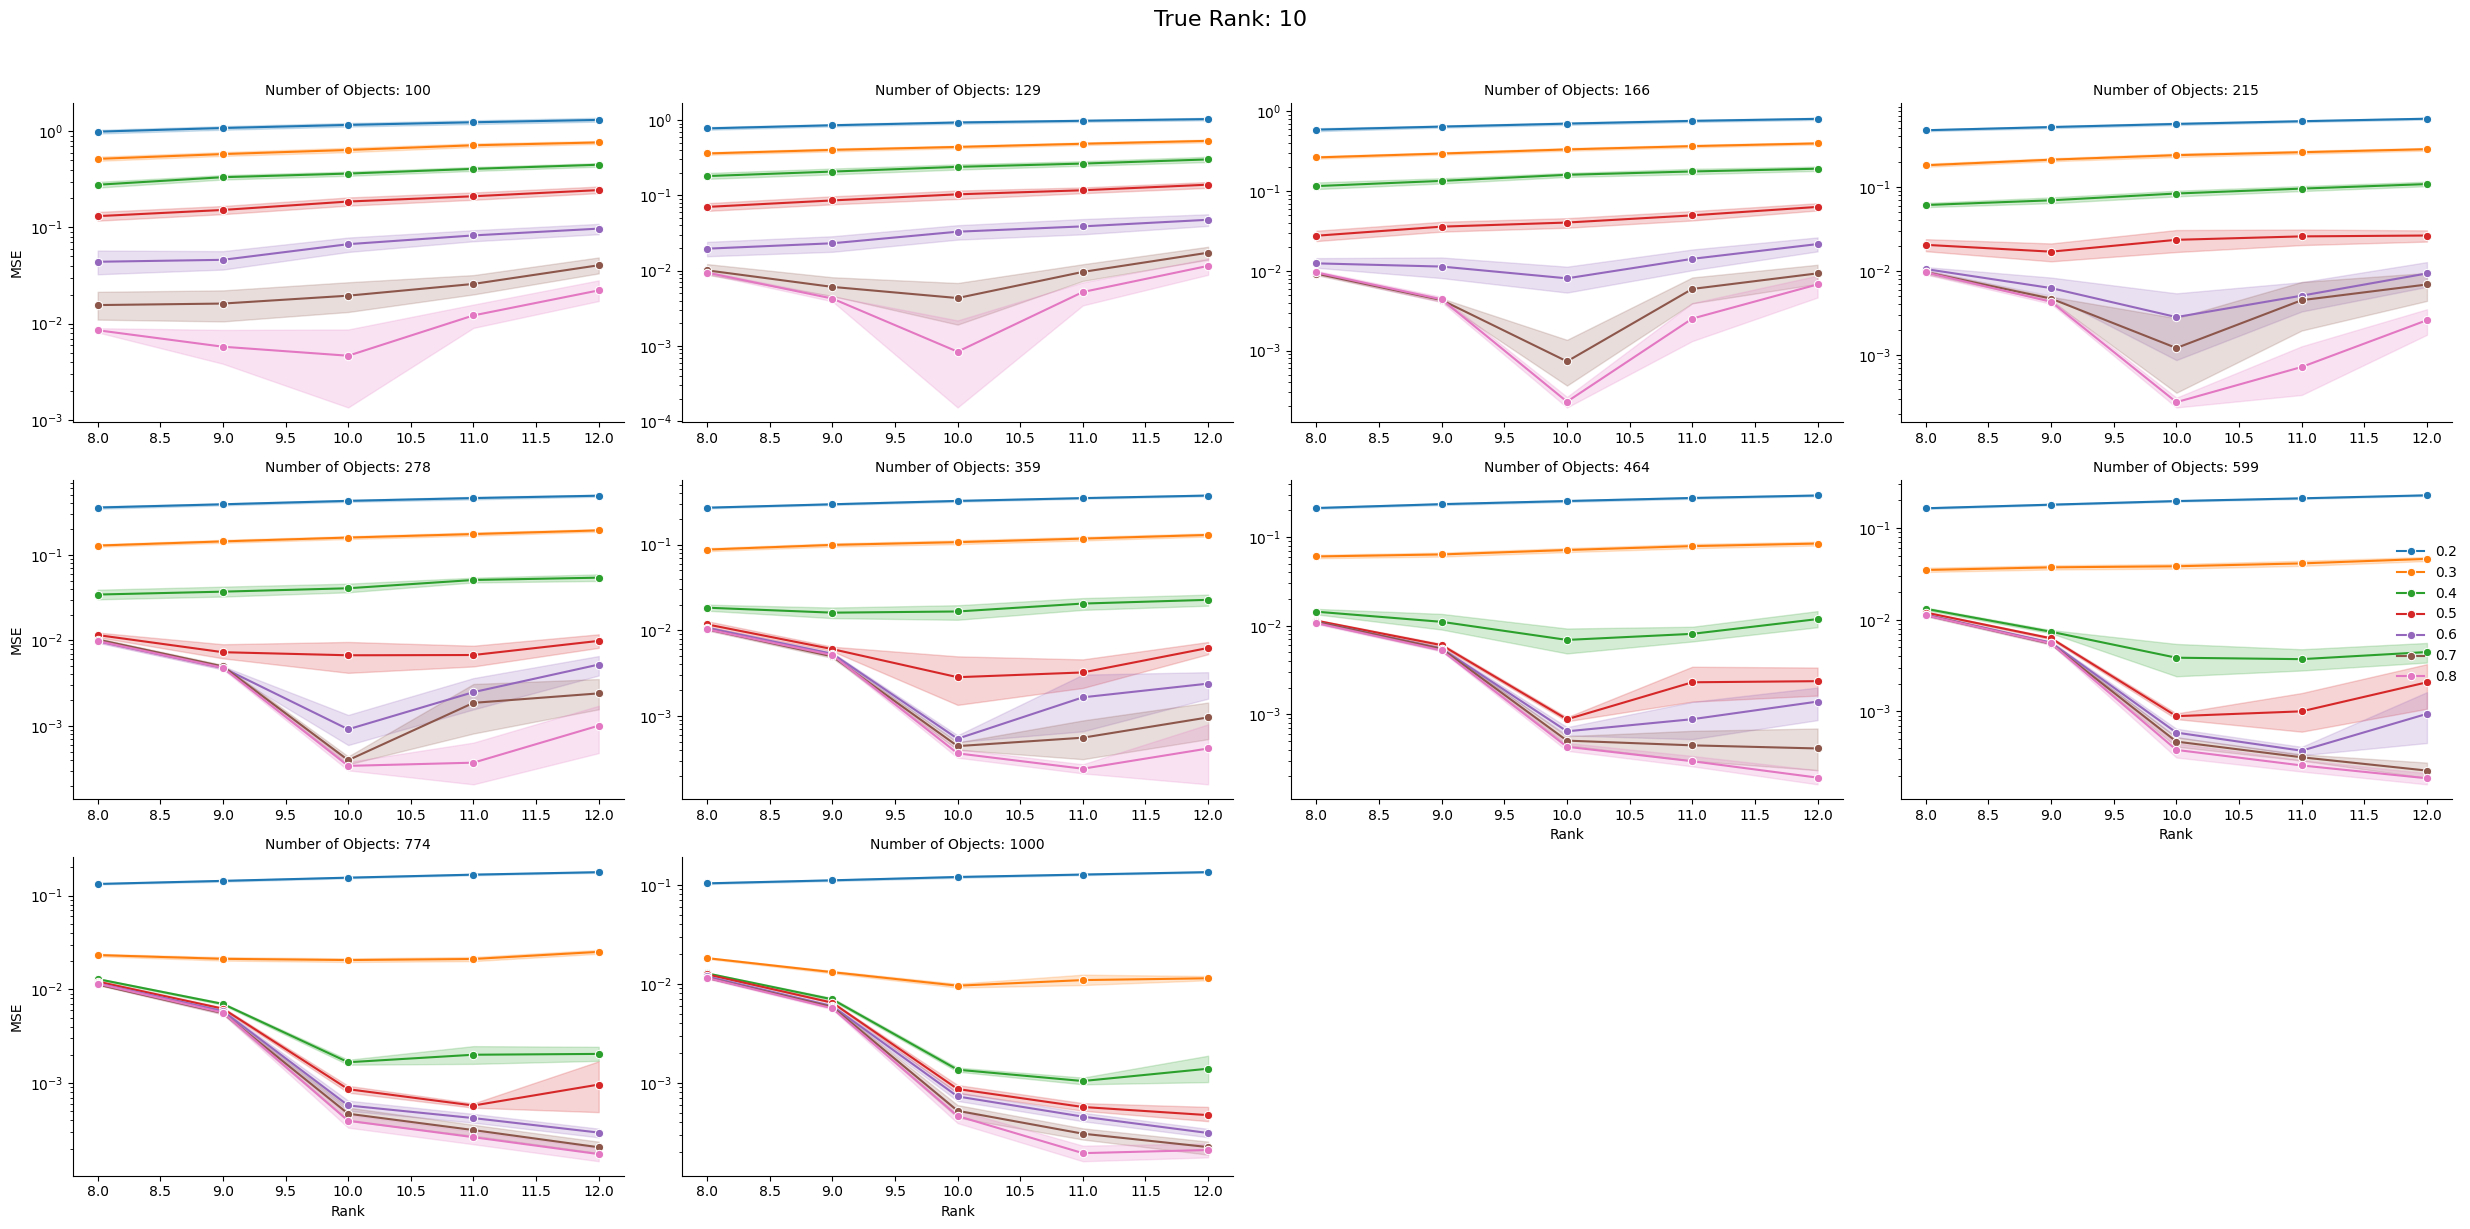

<Figure size 1920x1440 with 0 Axes>

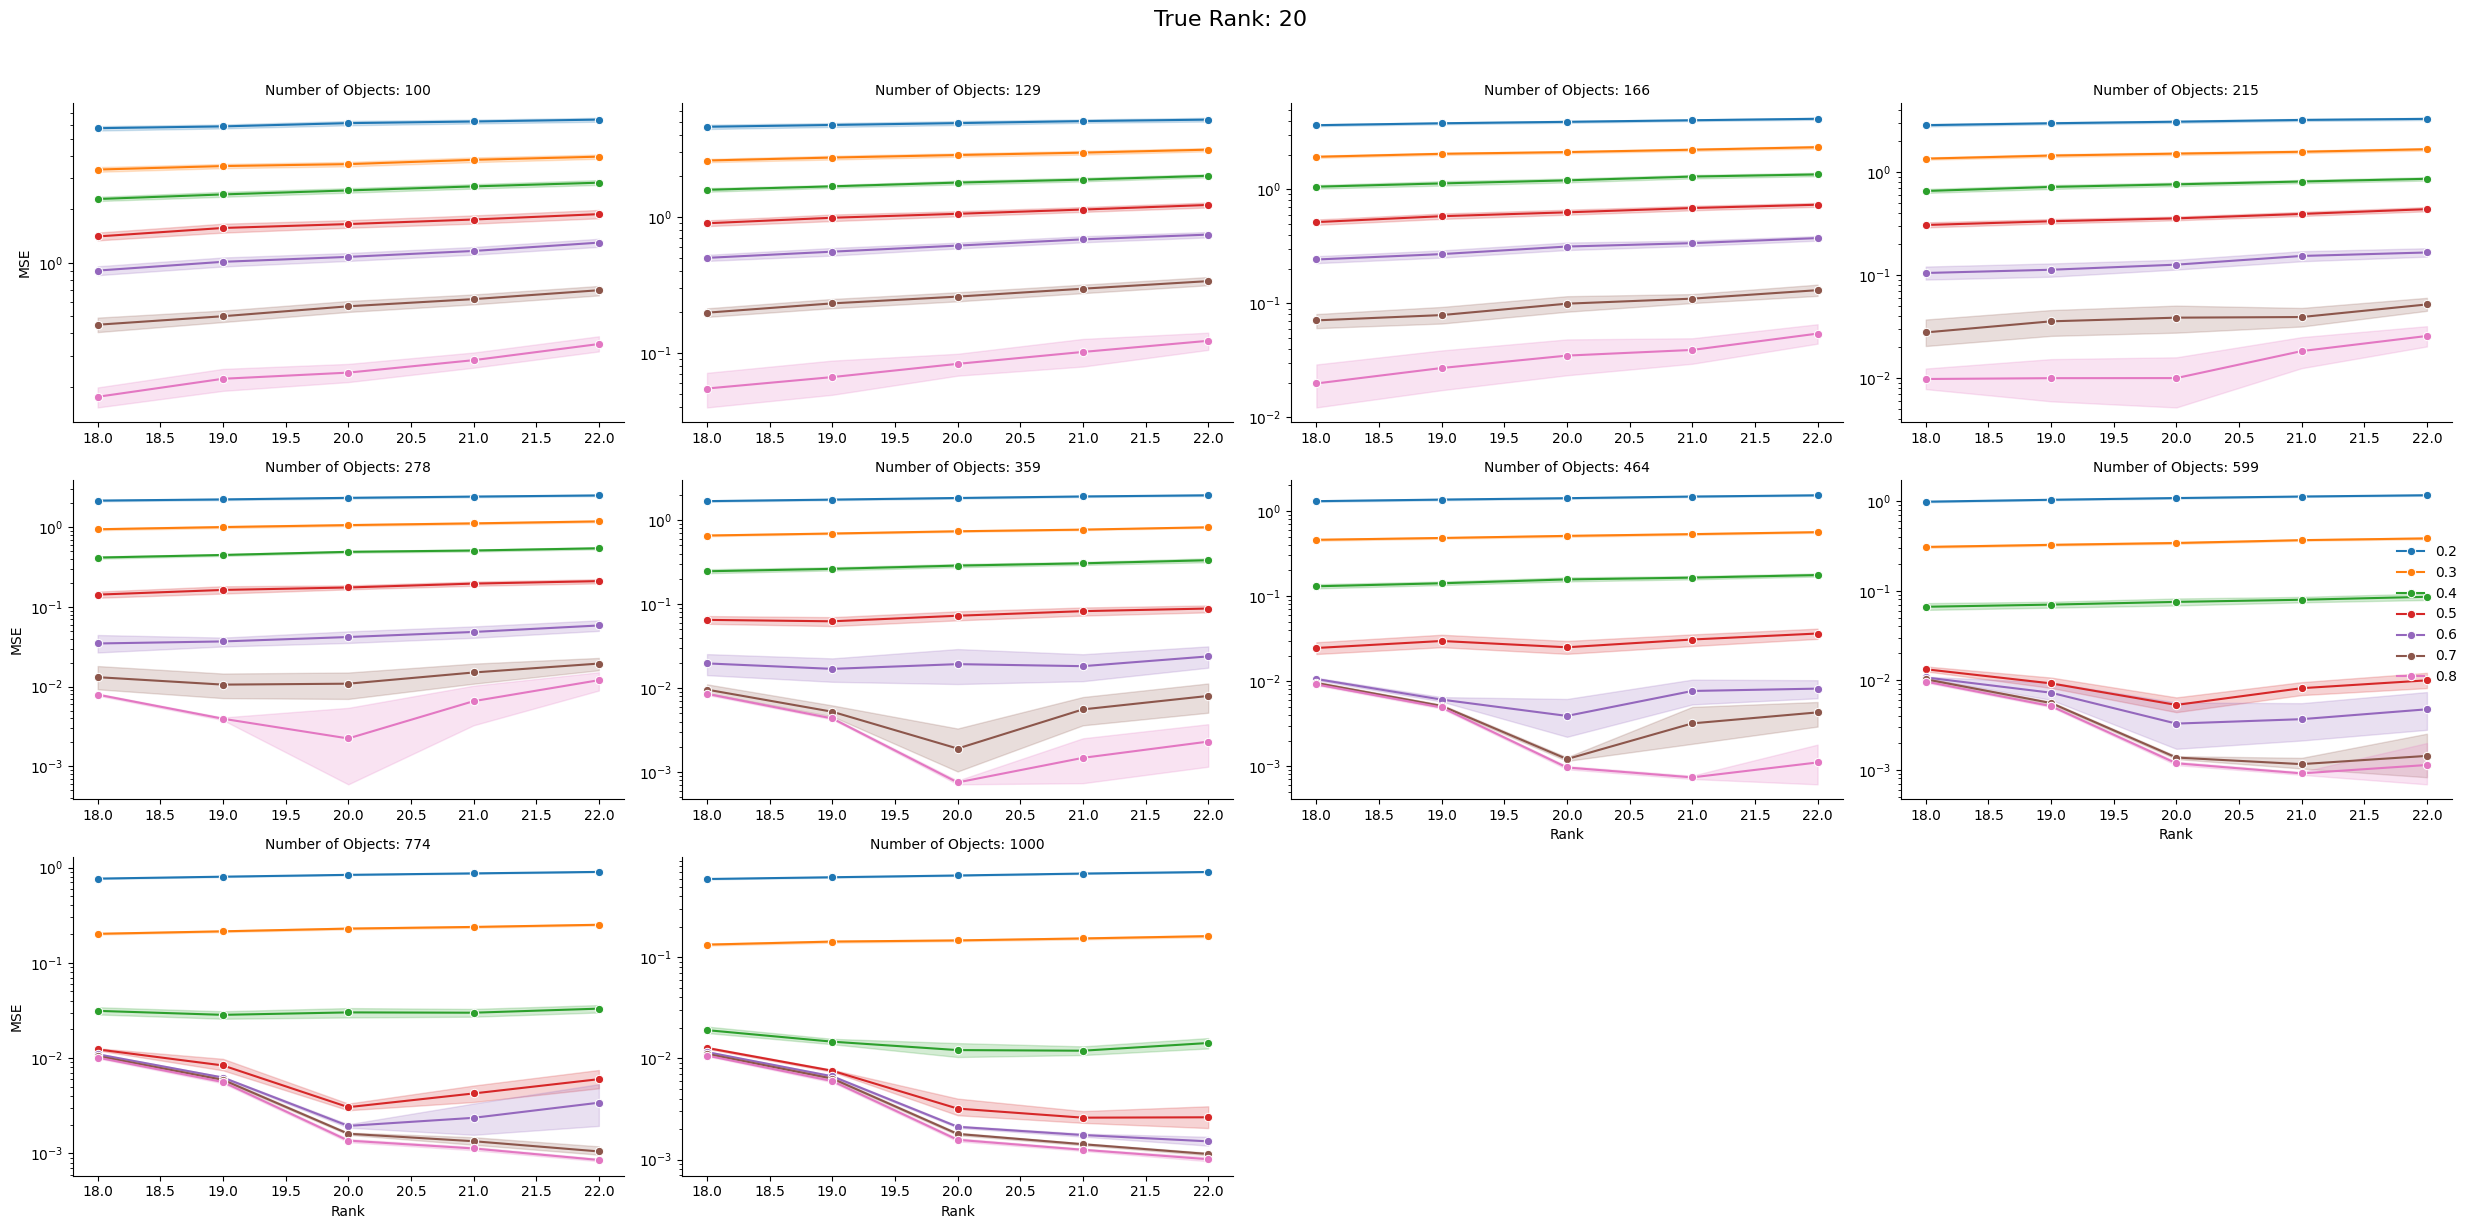

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../results/rank_detection_results.csv")

unique_true_ranks = sorted(df["true_rank"].unique())

for true_rank in unique_true_ranks:
    df_subset = df[df["true_rank"] == true_rank]

    plt.figure(dpi=300)
    g = sns.FacetGrid(
        df_subset,
        col="n_objects",
        col_wrap=4,
        height=4,
        aspect=1.5,
        sharey=False,
        sharex=False,
    )
    g.map_dataframe(
        sns.lineplot,
        x="rank",
        y="mse",
        hue="train_ratio",
        marker="o",
        palette="tab10",
    )
    g.add_legend()
    g.set_axis_labels("Rank", "MSE")
    g.set_titles("Number of Objects: {col_name}")

    for ax in g.axes.flat:
        ax.set_yscale("log")

    plt.suptitle(f"True Rank: {true_rank}", y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

Unique true_rank values: [np.int64(5), np.int64(10), np.int64(20)]
Unique n_objects values: [np.int64(100), np.int64(129), np.int64(166), np.int64(215), np.int64(278), np.int64(359), np.int64(464), np.int64(599), np.int64(774), np.int64(1000)]
Unique train_ratio values: [np.float64(0.2), np.float64(0.3), np.float64(0.4), np.float64(0.5), np.float64(0.6), np.float64(0.7), np.float64(0.8)]

Data availability by true_rank:
True rank 5: 70 combinations
True rank 10: 2 combinations
True rank 20: 0 combinations

True rank 5: 10 data points
  Object counts: [np.int64(100), np.int64(129), np.int64(166), np.int64(215), np.int64(278), np.int64(359), np.int64(464), np.int64(599), np.int64(774), np.int64(1000)]
  Optimal ratios: [np.float64(0.6), np.float64(0.6), np.float64(0.5), np.float64(0.6), np.float64(0.4), np.float64(0.4), np.float64(0.3), np.float64(0.3), np.float64(0.3), np.float64(0.8)]

True rank 10: 1 data points
  Object counts: [np.int64(129)]
  Optimal ratios: [np.float64(0.8)]

Tru

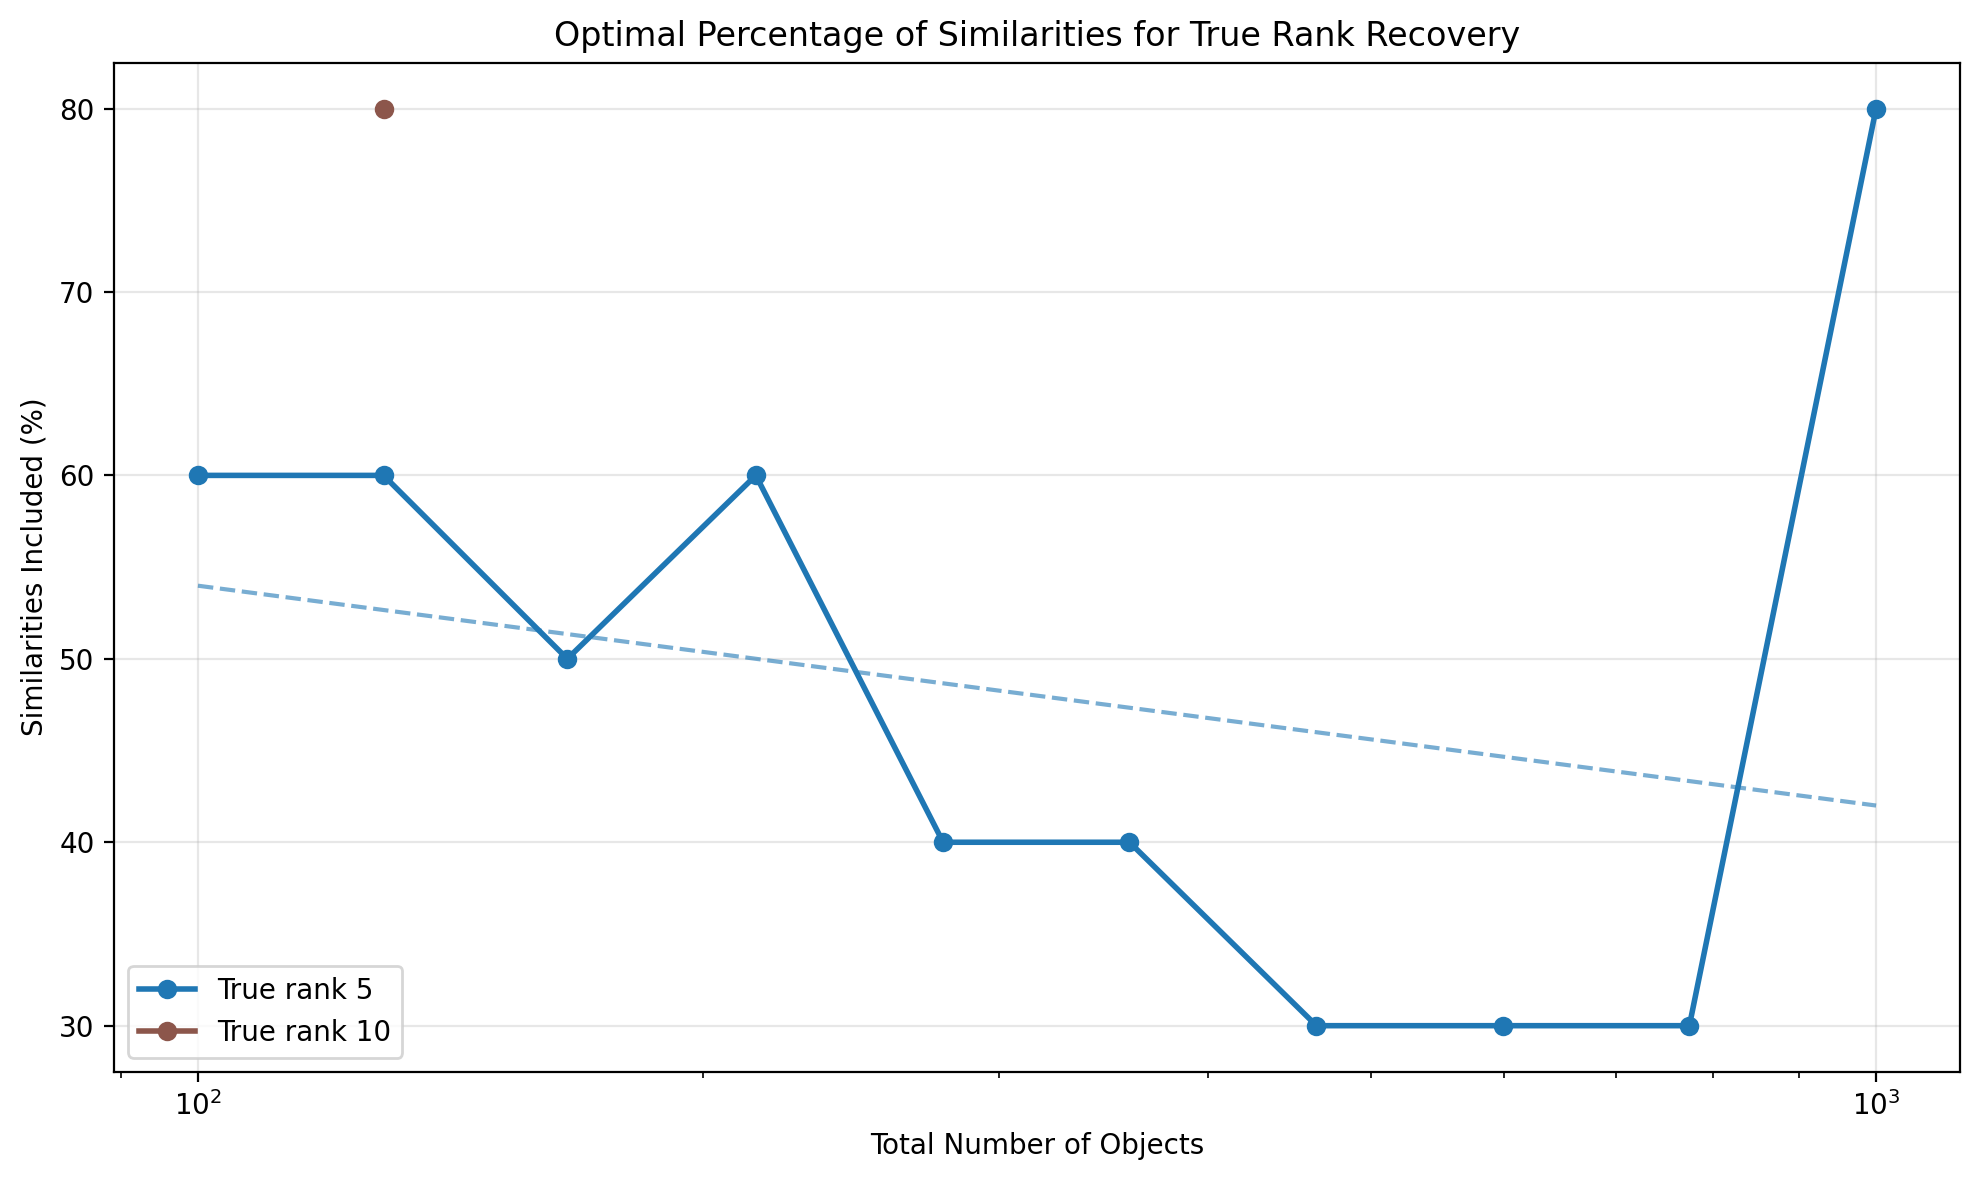

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("../results/rank_detection_results.csv")

# Debug: Check unique values
print("Unique true_rank values:", sorted(df["true_rank"].unique()))
print("Unique n_objects values:", sorted(df["n_objects"].unique()))
print("Unique train_ratio values:", sorted(df["train_ratio"].unique()))

best_ranks = df.groupby(["n_objects", "train_ratio", "trial_id"])["mse"].idxmin()
best_ranks_df = df.loc[best_ranks]

best_ranks_df["correct_rank"] = best_ranks_df["rank"] == best_ranks_df["true_rank"]
accuracy_df = (
    best_ranks_df.groupby(["n_objects", "train_ratio", "true_rank"])["correct_rank"]
    .mean()
    .reset_index()
)

# Debug: Check what data we have for each true_rank
print("\nData availability by true_rank:")
for true_rank in sorted(df["true_rank"].unique()):
    subset_count = len(accuracy_df[accuracy_df["true_rank"] == true_rank])
    print(f"True rank {true_rank}: {subset_count} combinations")

plt.figure(figsize=(10, 6), dpi=200)

colors = plt.cm.tab10(np.linspace(0, 1, len(df["true_rank"].unique())))
lines_plotted = 0

for i, true_rank in enumerate(sorted(df["true_rank"].unique())):
    optimal_ratios = []
    object_counts = []

    for n_obj in sorted(df["n_objects"].unique()):
        subset = accuracy_df[
            (accuracy_df["n_objects"] == n_obj)
            & (accuracy_df["true_rank"] == true_rank)
        ]
        if len(subset) > 0:
            best_ratio = subset.loc[subset["correct_rank"].idxmax(), "train_ratio"]
            optimal_ratios.append(best_ratio)
            object_counts.append(n_obj)

    print(f"\nTrue rank {true_rank}: {len(object_counts)} data points")
    if len(object_counts) > 0:
        print(f"  Object counts: {object_counts}")
        print(f"  Optimal ratios: {optimal_ratios}")

    if len(object_counts) > 0:
        plt.plot(
            object_counts,
            np.array(optimal_ratios) * 100,
            "o-",
            linewidth=2,
            markersize=6,
            color=colors[i],
            label=f"True rank {true_rank}",
        )
        lines_plotted += 1

        if len(object_counts) > 1:
            z = np.polyfit(np.log10(object_counts), np.array(optimal_ratios) * 100, 1)
            p = np.poly1d(z)
            plt.plot(
                object_counts,
                p(np.log10(object_counts)),
                "--",
                alpha=0.6,
                color=colors[i],
            )

print(f"\nTotal lines plotted: {lines_plotted}")

plt.xlabel("Total Number of Objects")
plt.ylabel("Similarities Included (%)")
plt.title("Optimal Percentage of Similarities for True Rank Recovery")
plt.grid(True, alpha=0.3)
plt.legend()
plt.xscale("log")
plt.tight_layout()
plt.show()

/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/LOCAL/fmahner/similarity-factorization/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)


<Figure size 3000x800 with 0 Axes>

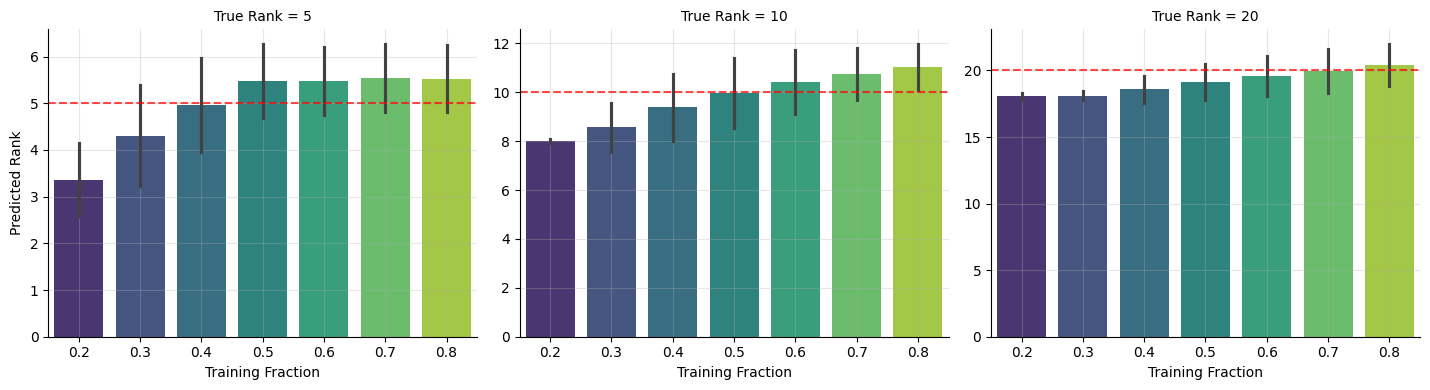

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../results/rank_detection_results.csv")

predicted_ranks = df.loc[
    df.groupby(["n_objects", "train_ratio", "trial_id", "true_rank"])["mse"].idxmin()
][["n_objects", "train_ratio", "trial_id", "true_rank", "rank", "mse"]].copy()

predicted_ranks = predicted_ranks.rename(columns={"rank": "predicted_rank"})

plt.figure(figsize=(15, 4), dpi=200)
g = sns.FacetGrid(
    predicted_ranks,
    col="true_rank",
    height=4,
    aspect=1.2,
    sharey=False,
)
g.map_dataframe(
    sns.barplot,
    x="train_ratio",
    y="predicted_rank",
    errorbar="sd",
    palette="viridis",
)
g.set_axis_labels("Training Fraction", "Predicted Rank")
g.set_titles("True Rank = {col_name}")

for ax, true_rank in zip(g.axes.flat, sorted(predicted_ranks["true_rank"].unique())):
    ax.axhline(y=true_rank, color="red", linestyle="--", alpha=0.7)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

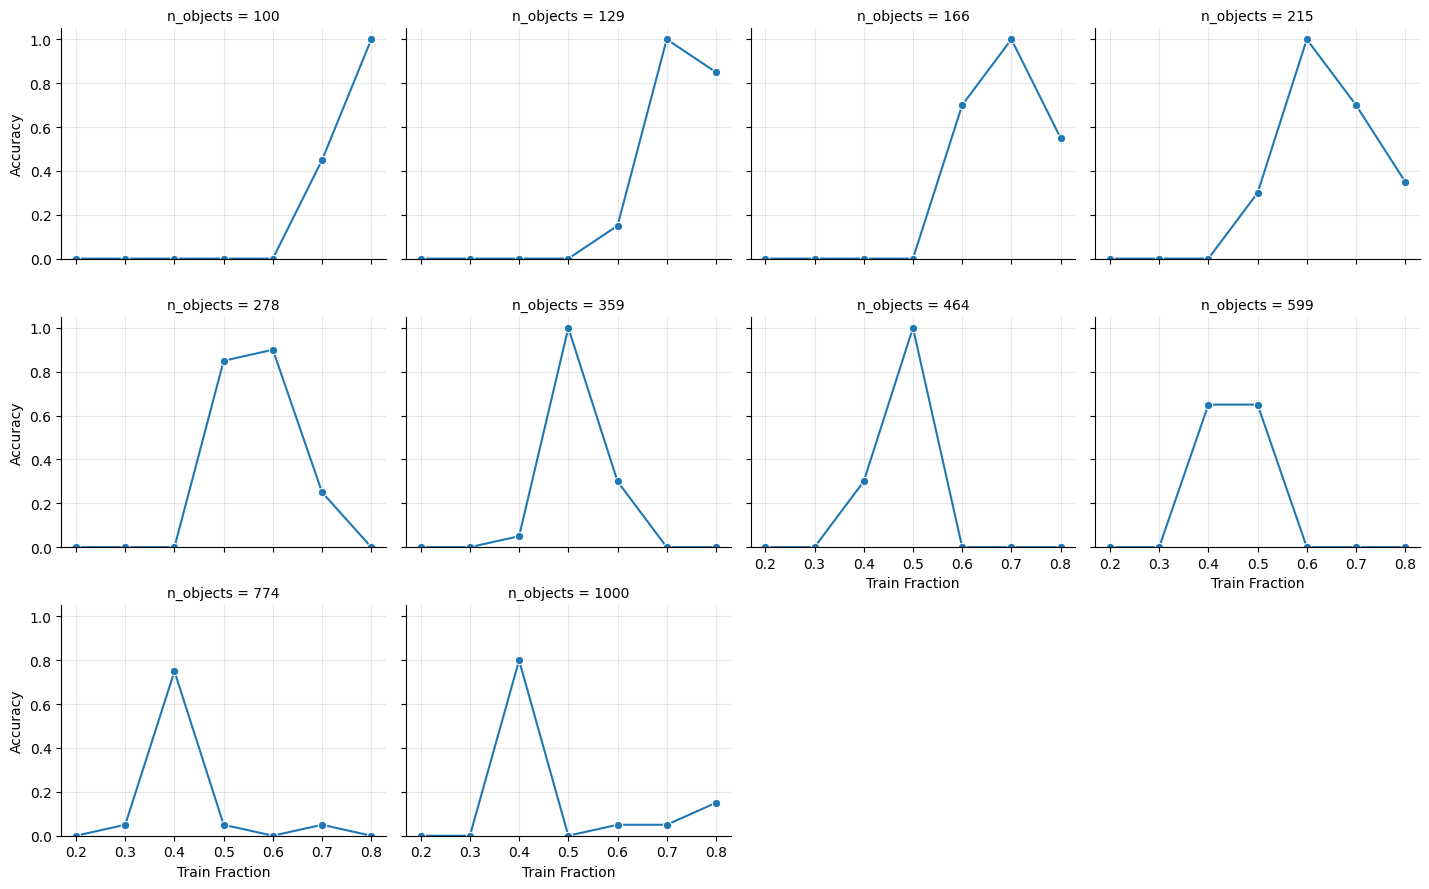

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("../results/rank_selection/rank_detection_full_results.csv")

# For each (n_objects, train_ratio, trial_id), find the rank with minimum mse
best_ranks = df.loc[
    df.groupby(["n_objects", "train_ratio", "trial_id"])["mse"].idxmin()
]

# Add a column indicating whether the selected rank matches the true rank
best_ranks["correct_rank"] = (best_ranks["rank"] == best_ranks["true_rank"]).astype(int)

# Compute accuracy (fraction of correct rank selections) for each (n_objects, train_ratio)
accuracy = (
    best_ranks.groupby(["n_objects", "train_ratio"])["correct_rank"]
    .mean()
    .reset_index()
    .rename(columns={"correct_rank": "accuracy"})
)

# Plot accuracy as a function of train_ratio, faceted by n_objects
g = sns.FacetGrid(
    accuracy,
    col="n_objects",
    col_wrap=4,
    sharey=True,
    height=3,
    aspect=1.2,
)
g.map_dataframe(sns.lineplot, x="train_ratio", y="accuracy", marker="o")
g.set_axis_labels("Train Fraction", "Accuracy")
g.set_titles("n_objects = {col_name}")
for ax in g.axes.flatten():
    ax.set_ylim(0, 1.05)
    ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Checking the rank selection for the things-monkey dataset

In [11]:
# things-monkye
dataset = load_dataset("things-monkey-2k")

rsm = dataset.rsm
rsm_pos = (rsm - rsm.min()) / (rsm.max() - rsm.min())
n = rsm.shape[0]
repeats = 3

ratio = 0.3
df_full = find_best_rank(
    rsm_pos,
    range(5, 45, 10),
    train_ratio=ratio,
    similarity_measure="cosine",
    n_repeats=repeats,
)

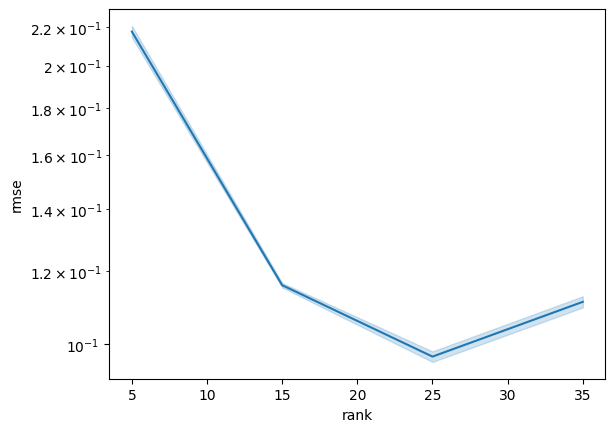

In [12]:
sns.lineplot(data=df_full, x="rank", y="rmse", errorbar="sd")
plt.yscale("log")
plt.show()

In [5]:
from srf.mixed.admm import ADMM
from srf.plotting import plot_images_from_embedding
from srf.datasets import load_dataset
from tools.rsa import compute_similarity

dataset = load_dataset("things-monkey-22k", min_reliab=0.1)

x = dataset.it
rsm = compute_similarity(x, x, "gaussian_kernel")

model = ADMM(rank=10, max_outer=10, w_inner=50, tol=0.0, verbose=True, rho=1.0)

w = model.fit_transform(rsm)


# fig = plot_images_from_embedding(w, dataset.filenames, top_k=10, dpi=100)

# # w_plus = model.fit_transform(s_plus)
# # w_minus = model.fit_transform(s_minus)

# # fig = plot_images_from_embedding(w_plus, images, top_k=10, dpi=100)
# # fig = plot_images_from_embedding(w_minus, images, top_k=10, dpi=100)

Sigma not provided, estimating from data using median distance
